In [39]:
import pymongo as pm #import MongoClient only
import ast
import numpy as np
from datetime import datetime, timezone
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import array
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon
import pandas as pd
client = pm.MongoClient('bigdatadb.polito.it',
ssl=True,
authSource = 'carsharing',
username = 'ictts',
password ='Ict4SM22!',
tlsAllowInvalidCertificates=True)
db = client['carsharing'] #Choose the DB to use
Bookings_col = db['ictts_PermanentBookings'] # Collection for Car2go to use
Enjoy_Bookings_col = db['ictts_enjoy_PermanentBookings'] # Collection for Car2go to use

with open('data/IMQ/Zone/TorinoZonesArray.geojson') as file:
    lines = file.readlines()
    
zones = [ast.literal_eval(line)[0] for line in lines]

In [4]:
zones

[[[[[7.691863740888242, 45.070489011785504],
    [7.691502277482972, 45.069976267574496],
    [7.6931049096062, 45.06940050107999],
    [7.693700390732412, 45.06917326756794],
    [7.694659975840831, 45.068837671021356],
    [7.694171859859442, 45.068237969925804],
    [7.693838193427549, 45.06782907174575],
    [7.694954578554977, 45.06740524790493],
    [7.696057454235982, 45.06698125884916],
    [7.695274080838461, 45.06637819028057],
    [7.695994498714531, 45.065909322902876],
    [7.696972771397907, 45.06527235899328],
    [7.697718763756376, 45.06479477065485],
    [7.698691242087296, 45.065548507951455],
    [7.698832714004479, 45.065401589987836],
    [7.69906763599841, 45.06542227031892],
    [7.69906279469674, 45.065390708773954],
    [7.699042169545366, 45.06537247014065],
    [7.699030276281492, 45.06535433098812],
    [7.699003903269591, 45.06532702503567],
    [7.698980500877238, 45.06530875474862],
    [7.698934977255672, 45.06528573149588],
    [7.698894509930546, 45.0

In [5]:
Bookings_col.find_one()

{'_id': ObjectId('5a3bb3af20c3dd47cf59003d'),
 'init_fuel': 53,
 'vendor': 'car2go',
 'exterior': 'GOOD',
 'vin': 'WME4533421K152664',
 'final_address': 'Corso Regina Margherita, 107, 10122 Torino TO',
 'engineType': 'CE',
 'final_date': datetime.datetime(2017, 11, 1, 0, 19, 45),
 'public_transport': {'duration': -1,
  'arrival_time': -1,
  'distance': -1,
  'arrival_date': -1},
 'final_loc': {'coordinates': [7.68634, 45.07567], 'type': 'Point'},
 'smartPhoneRequired': True,
 'init_time': 1509490770,
 'interior': 'GOOD',
 'init_address': 'Lungo Dora Napoli, 18A, 10152 Torino TO',
 'init_loc': {'coordinates': [7.68486, 45.08276], 'type': 'Point'},
 'driving': {'duration': 234, 'distance': 966},
 'final_time': 1509491985,
 'plate': '288/FF214SJ',
 'city': 'Torino',
 'final_fuel': 53,
 'init_date': datetime.datetime(2017, 10, 31, 23, 59, 30),
 'walking': {'duration': 746, 'distance': 982}}

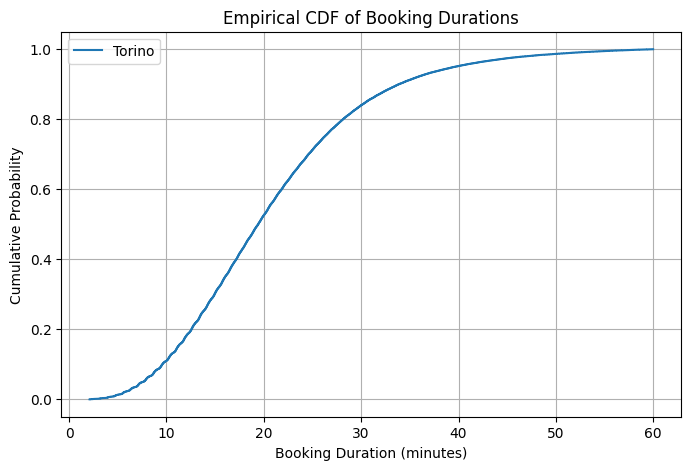

In [6]:
#Task 1: checking if data is already filtered
booking_duration = []
for doc in Bookings_col.find({"city": "Torino"}):
    booking_duration.append(doc["final_time"]- doc["init_time"])
    
booking_durations_np = np.array(booking_duration)/60
sorted_durations = np.sort(booking_durations_np)

cumulative_probabilities = np.arange(1, len(sorted_durations) + 1) / len(sorted_durations)

plt.figure(figsize=(8, 5))
plt.plot(sorted_durations, cumulative_probabilities, label="Torino")


plt.xlabel("Booking Duration (minutes)")
plt.ylabel("Cumulative Probability")
plt.title("Empirical CDF of Booking Durations")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
#Task 1: OD matrix of all bookings
od_matrix = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$match": { 
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix[i, j] = 0



In [40]:
#od_amtrix enjoy
od_matrix_e = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$match": { 
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Enjoy_Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix_e[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix_e[i, j] = 0



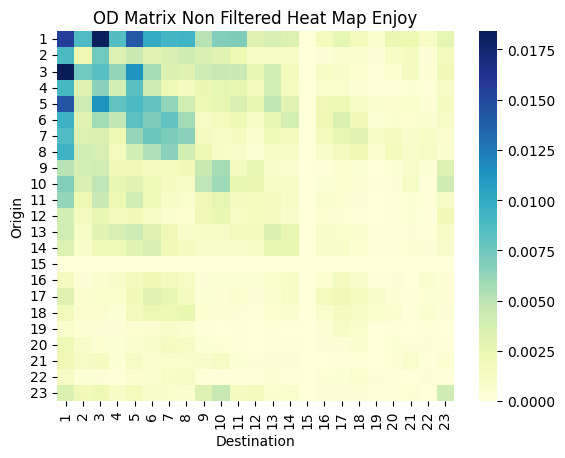

In [41]:
tot_sum = np.sum(od_matrix_e)
od_matrix_norm_e = od_matrix_e / tot_sum

plt.figure()
sns.heatmap(od_matrix_norm_e, cmap="YlGnBu", cbar=True, xticklabels=range(1, len(zones)+1), yticklabels=range(1, len(zones)+1))

plt.title("OD Matrix Non Filtered Heat Map Enjoy")
plt.xlabel("Destination")
plt.ylabel("Origin")

plt.show()

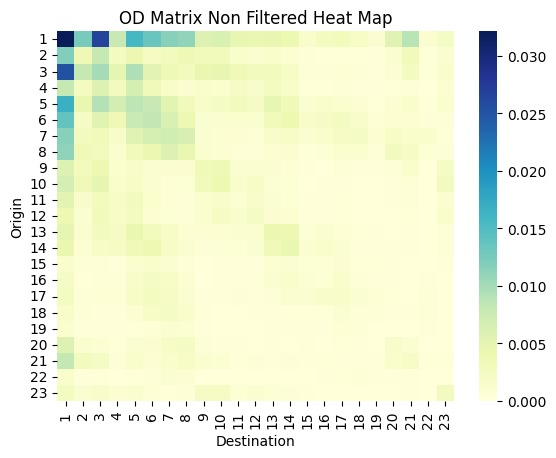

In [8]:
#Task 1: Heat map plot
tot_sum = np.sum(od_matrix)
od_matrix_norm = od_matrix / tot_sum

plt.figure()
sns.heatmap(od_matrix_norm, cmap="YlGnBu", cbar=True, xticklabels=range(1, len(zones)+1), yticklabels=range(1, len(zones)+1))

plt.title("OD Matrix Non Filtered Heat Map")
plt.xlabel("Destination")
plt.ylabel("Origin")

plt.show()


In [9]:
#Task 1a: filtering data by weekdays
od_matrix_weekdays = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$project": {
                    #"hour": { "$hour": "$init_date" },
                    "day": { "$dayOfWeek": "$init_date" },
                    "init_loc": 1,
                    "final_loc": 1
                } 
            },
            {
                "$match": { 
                    "day": { 
                        "$gt": 1, 
                        "$lt":7 },
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix_weekdays[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix_weekdays[i, j] = 0

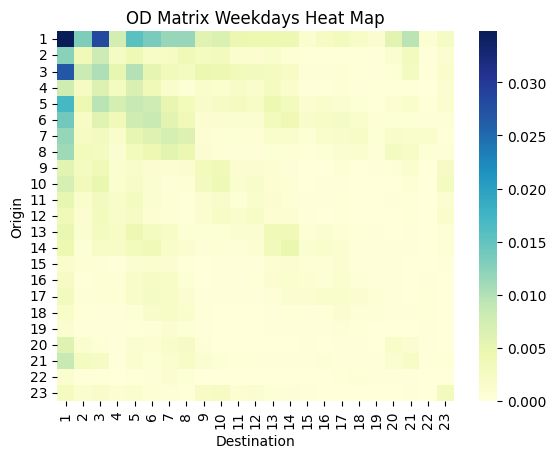

In [10]:
tot_sum = np.sum(od_matrix_weekdays)
od_matrix_weekdays_norm = od_matrix_weekdays / tot_sum

plt.figure()
sns.heatmap(od_matrix_weekdays_norm, cmap="YlGnBu", cbar=True, xticklabels=range(1, len(zones)+1), yticklabels=range(1, len(zones)+1))

plt.title("OD Matrix Weekdays Heat Map")
plt.xlabel("Destination")
plt.ylabel("Origin")

plt.show()

In [11]:
#Task 1a: filtering data by weekends
od_matrix_weekends = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$project": {
                    #"hour": { "$hour": "$init_date" },
                    "day": { "$dayOfWeek": "$init_date" },
                    "init_loc": 1,
                    "final_loc": 1
                } 
            },
            {
                "$match": { 
                    "day": { 
                        "$in": [1, 7]},
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix_weekends[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix_weekends[i, j] = 0

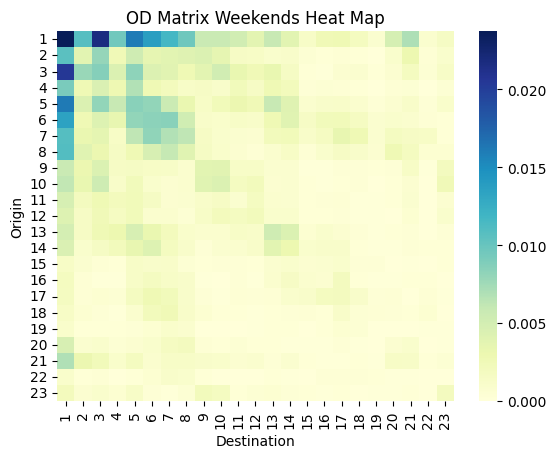

In [12]:
tot_sum = np.sum(od_matrix_weekends)
od_matrix_weekends_norm = od_matrix_weekends / tot_sum

plt.figure()
sns.heatmap(od_matrix_weekends_norm, cmap="YlGnBu", cbar=True, xticklabels=range(1, len(zones)+1), yticklabels=range(1, len(zones)+1))

plt.title("OD Matrix Weekends Heat Map")
plt.xlabel("Destination")
plt.ylabel("Origin")

plt.show()

In [13]:
pipeline = [
    {
        "$group": {
            "_id": None,
            "minDate": { "$min": "$init_date" }, 
            "maxDate": { "$max": "$init_date" }   
        }
    }
]

result = list(Enjoy_Bookings_col.aggregate(pipeline))

print("Start Date:", result[0]['minDate'])
print("End Date:", result[0]['maxDate'])


Start Date: 2017-09-01 00:03:29
End Date: 2017-10-31 23:58:50


In [14]:
#Task 1b: filter for just a week of data (week 36 of 2017) Start: Monday, September 4th, 2017
od_matrix_week36 = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$project": {
                    "week": { "$week": "$init_date" },
                    "day": { "$dayOfWeek": "$init_date" },
                    "year": { "$year": "$init_date" }, 
                    "init_loc": 1,
                    "final_loc": 1
                } 
            },
            {
                "$match": { 
                    "day": { 
                        "$gt": 1, 
                        "$lt":7 },
                    "week": { "$eq": 36 },
                    "year": { "$eq": 2017 },
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix_week36[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix_week36[i, j] = 0

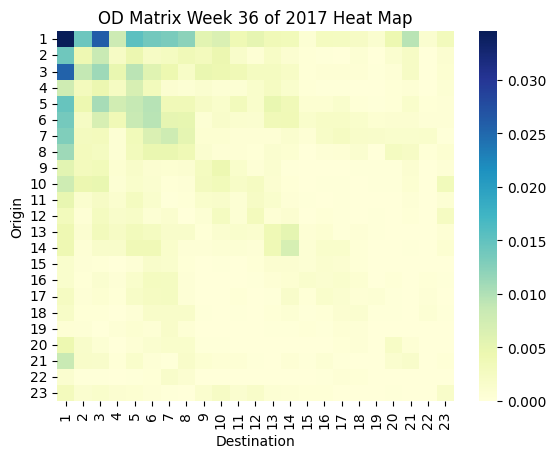

In [15]:
tot_sum = np.sum(od_matrix_week36)
od_matrix_week36_norm = od_matrix_week36 / tot_sum

plt.figure()
sns.heatmap(od_matrix_week36_norm, cmap="YlGnBu", cbar=True, xticklabels=range(1, len(zones)+1), yticklabels=range(1, len(zones)+1))

plt.title("OD Matrix Week 36 of 2017 Heat Map")
plt.xlabel("Destination")
plt.ylabel("Origin")

plt.show()

In [16]:
#Task 1b: filter for just a week of data (week 39 of 2017) Start: Monday, September 25, 2017
od_matrix_week39 = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$project": {
                    "week": { "$week": "$init_date" },
                    "day": { "$dayOfWeek": "$init_date" },
                    "year": { "$year": "$init_date" }, 
                    "init_loc": 1,
                    "final_loc": 1
                } 
            },
            {
                "$match": { 
                    "day": { 
                        "$gt": 1, 
                        "$lt":7 },
                    "week": { "$eq": 39 },
                    "year": { "$eq": 2017 },
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix_week39[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix_week39[i, j] = 0

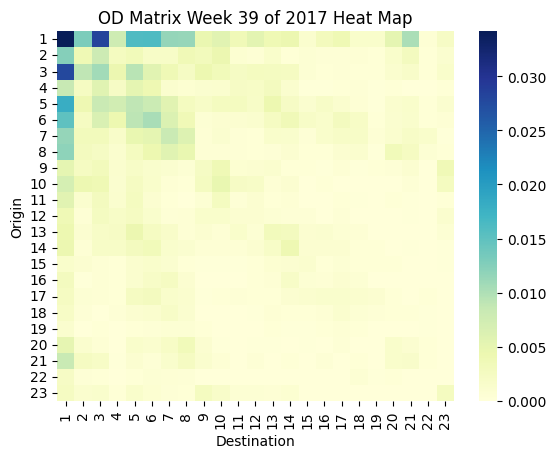

In [17]:
tot_sum = np.sum(od_matrix_week39)
od_matrix_week39_norm = od_matrix_week39 / tot_sum

plt.figure()
sns.heatmap(od_matrix_week39_norm, cmap="YlGnBu", cbar=True, xticklabels=range(1, len(zones)+1), yticklabels=range(1, len(zones)+1))

plt.title("OD Matrix Week 39 of 2017 Heat Map")
plt.xlabel("Destination")
plt.ylabel("Origin")

plt.show()

In [18]:
#Task 1b: filter for just a week of data (week 39 of 2017) Start: Monday, September 25, 2017
od_matrix_week39_enjoy = np.zeros((len(zones), len(zones)), dtype=int)
for i, origin in enumerate(zones):
    result = []  
    for j, dest in enumerate(zones):
        pipeline = [
            {
                "$project": {
                    "week": { "$week": "$init_date" },
                    "day": { "$dayOfWeek": "$init_date" },
                    "year": { "$year": "$init_date" }, 
                    "init_loc": 1,
                    "final_loc": 1
                } 
            },
            {
                "$match": { 
                    "day": { 
                        "$gt": 1, 
                        "$lt":7 },
                    "week": { "$eq": 39 },
                    "year": { "$eq": 2017 },
                    "init_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": origin 
                            }
                        }
                    },
                    "final_loc": {
                        "$geoWithin": {
                            "$geometry": {
                                "type": "MultiPolygon",
                                "coordinates": dest  
                            }
                        }
                    }
                }
            },
            {
                "$count": "tot"  
            }
        ]
        
        aggregation_result = list(Enjoy_Bookings_col.aggregate(pipeline))
        if aggregation_result:
            od_matrix_week39_enjoy[i, j] = aggregation_result[0]["tot"]
        else:
            od_matrix_week39_enjoy[i, j] = 0

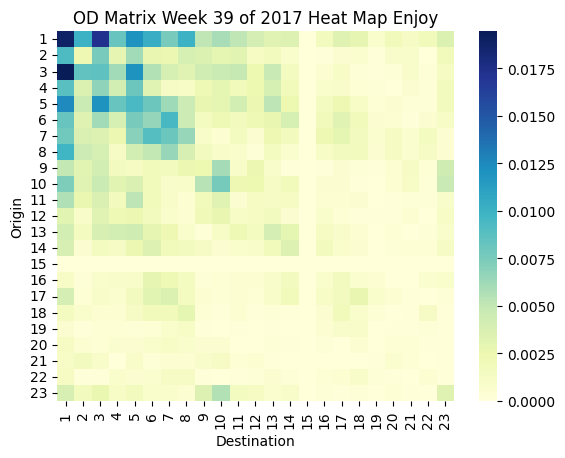

In [19]:
tot_sum = np.sum(od_matrix_week39_enjoy)
od_matrix_week39_enjoy_norm = od_matrix_week39_enjoy / tot_sum

plt.figure()
sns.heatmap(od_matrix_week39_enjoy_norm, cmap="YlGnBu", cbar=True, xticklabels=range(1, len(zones)+1), yticklabels=range(1, len(zones)+1))

plt.title("OD Matrix Week 39 of 2017 Heat Map Enjoy")
plt.xlabel("Destination")
plt.ylabel("Origin")

plt.show()

In [20]:
rand_matrix_A = np.random.rand(23, 23)
rand_matrix_A = rand_matrix_A / np.sum(rand_matrix_A)

rand_matrix_B = np.random.rand(23, 23)
rand_matrix_B = rand_matrix_B / np.sum(rand_matrix_B)

In [21]:
def simple_distance(matrix1, matrix2):
    return np.sum(np.abs(matrix1 - matrix2))

d1_rand = simple_distance(rand_matrix_A, rand_matrix_B)
print(f"Absolute distance between random matrixes: {d1_rand}")
d1_weeks = simple_distance(od_matrix_week36_norm, od_matrix_week39_norm)
print(f"Absolute distance between week 36 and 39: {d1_weeks}")
d1_platfrom = simple_distance(od_matrix_week39_norm, od_matrix_week39_enjoy_norm)
print(f"Absolute distance between Car2go and Enjoy: {d1_platfrom}")

Absolute distance between random matrixes: 0.663617862192655
Absolute distance between week 36 and 39: 0.22451423433648007
Absolute distance between Car2go and Enjoy: 0.40182221926214634


In [22]:
def euclidean_distance(matrix1, matrix2):
    return np.sqrt(np.sum((matrix1 - matrix2)**2))

d2_rand = euclidean_distance(rand_matrix_A, rand_matrix_B)
print(f"Euclidean distance between random matrixes: {d2_rand}")
d2_weeks = euclidean_distance(od_matrix_week36_norm, od_matrix_week39_norm)
print(f"Euclidean distance between week 36 and 39: {d2_weeks}")
d2_platfrom = euclidean_distance(od_matrix_week39_norm, od_matrix_week39_enjoy_norm)
print(f"Euclidean distance between Car2go and Enjoy: {d2_platfrom}")

Euclidean distance between random matrixes: 0.035326081643138815
Euclidean distance between week 36 and 39: 0.014469360864313519
Euclidean distance between Car2go and Enjoy: 0.033929065764338504


In [23]:
def max_absolute_difference(A, B):
    absolute_diff = np.abs(A - B)
    return np.max(absolute_diff)

dMax_rand = max_absolute_difference(rand_matrix_A, rand_matrix_B)
print(f"Max absolute difference between random matrixes: {dMax_rand}")
dMax_weeks = max_absolute_difference(od_matrix_week36_norm, od_matrix_week39_norm)
print(f"Max absolute difference between week 36 and 39: {dMax_weeks}")
dMax_platfrom = max_absolute_difference(od_matrix_week39_norm, od_matrix_week39_enjoy_norm)
print(f"Max absolute difference between Car2go and Enjoy: {dMax_platfrom}")

Max absolute difference between random matrixes: 0.0037538577277645693
Max absolute difference between week 36 and 39: 0.003416542416515265
Max absolute difference between Car2go and Enjoy: 0.015290397778564238


In [24]:
def compute_dm(A, B):
    M = A - B
    n = M.shape[0]  # Size of the matrix
    x = np.random.rand(n)  # Random vector
    x /= np.linalg.norm(x)  # Normalize it to have ||x|| = 1
    for _ in range(100):
        x = M.T @ (M @ x)  # Multiply by M.T @ M
        x /= np.linalg.norm(x)  # Normalize to ensure ||x|| = 1
    max_norm = np.linalg.norm(M @ x)
    return max_norm

dNorm_rand = compute_dm(rand_matrix_A, rand_matrix_B)
print(f"Max norm of the difference between random matrixes: {dNorm_rand}")
dNorm_weeks = compute_dm(od_matrix_week36_norm, od_matrix_week39_norm)
print(f"Max norm of the difference between week 36 and 39: {dNorm_weeks}")
dNorm_platfrom = compute_dm(od_matrix_week39_norm, od_matrix_week39_enjoy_norm)
print(f"Max norm of the difference between Car2go and Enjoy: {dNorm_platfrom}")

Max norm of the difference between random matrixes: 0.013950770072021602
Max norm of the difference between week 36 and 39: 0.007273287611600087
Max norm of the difference between Car2go and Enjoy: 0.02716255379026128


In [25]:

def compute_dm2(A, B, iterations=100, tol=1e-9):
    # Step 1: Compute the difference matrix M = A - B
    M = A - B
    n = M.shape[0]  # Number of rows/columns (assuming square matrix)
    
    # Step 2: Start with a random vector x
    x = np.random.rand(n)
    x /= np.linalg.norm(x)  # Normalize x to have ||x|| = 1
    
    # Step 3: Perform power iteration
    prev_norm = 0
    for _ in range(iterations):
        # Multiply M by the current vector x
        x = M @ x
        
        # Compute the 2-norm of the resulting vector
        current_norm = np.linalg.norm(x)
        
        # Normalize x for the next iteration
        x /= current_norm
        
        # Check for convergence
        if abs(current_norm - prev_norm) < tol:
            break
        prev_norm = current_norm
    
    return current_norm

dNorm_rand2 = compute_dm2(rand_matrix_A, rand_matrix_B)
print(f"Max norm of the difference between random matrixes: {dNorm_rand2}")
dNorm_weeks2 = compute_dm2(od_matrix_week36_norm, od_matrix_week39_norm)
print(f"Max norm of the difference between week 36 and 39: {dNorm_weeks2}")
dNorm_platfrom2 = compute_dm2(od_matrix_week39_norm, od_matrix_week39_enjoy_norm)
print(f"Max norm of the difference between Car2go and Enjoy: {dNorm_platfrom2}")

Max norm of the difference between random matrixes: 0.008709119997508662
Max norm of the difference between week 36 and 39: 0.005145795821021329
Max norm of the difference between Car2go and Enjoy: 0.026708361578052623


In [26]:
#question 3


unipol_info = pd.read_csv('./data/Unipoldata/Info_TO.csv')
unipol_trips = pd.read_csv('./data/Unipoldata/Trips_OD_TO.csv')
imq_data = pd.read_csv('./data/IMQ/IMQData_Torino.csv')

unipol_data = pd.merge(unipol_trips, unipol_info, on='id_veicolo')

print("UnipolTech Data:")
print(unipol_data.head())
print("IMQ Data:")
print(imq_data.head())

UnipolTech Data:
   id_veicolo  id_viaggio        istante_start  lat_start  lon_start  \
0           1           2  2024-08-27 21:15:03     45.069      7.698   
1           1           4  2024-08-27 21:22:47     45.069      7.698   
2           1           5  2024-08-28 08:16:42     45.083      7.675   
3           1           6  2024-08-28 11:47:37     45.068      7.687   
4           1           7  2024-08-29 12:22:22     45.083      7.675   

          istante_stop  lat_stop  lon_stop commerciale  eta_approx genere  
0  2024-08-27 21:16:05    45.069     7.698           N          47      M  
1  2024-08-27 21:32:03    45.083     7.675           N          47      M  
2  2024-08-28 08:29:07    45.067     7.688           N          47      M  
3  2024-08-28 11:54:02    45.083     7.675           N          47      M  
4  2024-08-29 12:31:44    45.077     7.668           N          47      M  
IMQ Data:
    ID_INT  GENDER  AGE  MOTIVATION ORI_ZONE           DEP_HOUR DST_ZONE  \
0  81393

In [27]:
from shapely.geometry import Point, Polygon, mapping
import json


with open('./data/IMQ/Zone/TorinoZonescol.geojson') as file:
    data = json.load(file)

zones = []
for feature in data['features']:
    coordinates = feature['geometry']['coordinates']
    if feature['geometry']['type'] == 'Polygon':
        zones.append(Polygon(coordinates[0]))
    elif feature['geometry']['type'] == 'MultiPolygon':
        for polygon in coordinates:
            zones.append(Polygon(polygon[0]))


zone_gdf = gpd.GeoDataFrame(geometry=zones)


def find_zone(lat, lon):
    point = Point(lon, lat)
    for i, zone in enumerate(zones):
        if zone.contains(point):
            return i
    return -1

unipol_data['ORI_ZONE'] = unipol_data.apply(lambda row: find_zone(row['lat_start'], row['lon_start']), axis=1)
unipol_data['DST_ZONE'] = unipol_data.apply(lambda row: find_zone(row['lat_stop'], row['lon_stop']), axis=1)

unipol_data = unipol_data[(unipol_data['ORI_ZONE'] != -1) & (unipol_data['DST_ZONE'] != -1)]

imq_data['ORI_ZONE'] = imq_data['ORI_ZONE'].str.replace('Q', '').astype(int)
imq_data['DST_ZONE'] = imq_data['DST_ZONE'].str.replace('Q', '').astype(int)

imq_data = imq_data[(imq_data['ORI_ZONE'] != -1) & (imq_data['DST_ZONE'] != -1)]

Distance between normalized UnipolTech and IMQ OD matrices: 0.030020623572022283


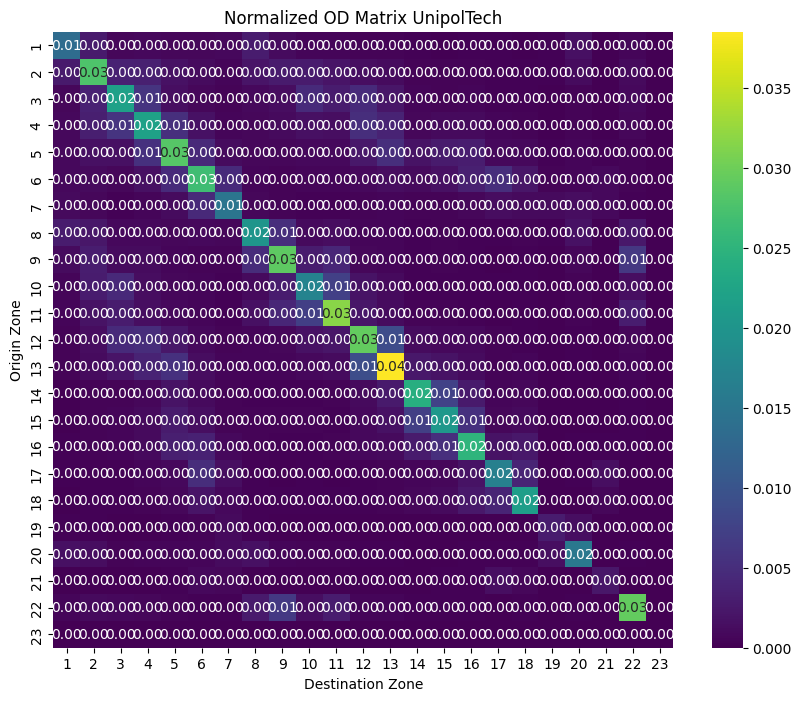

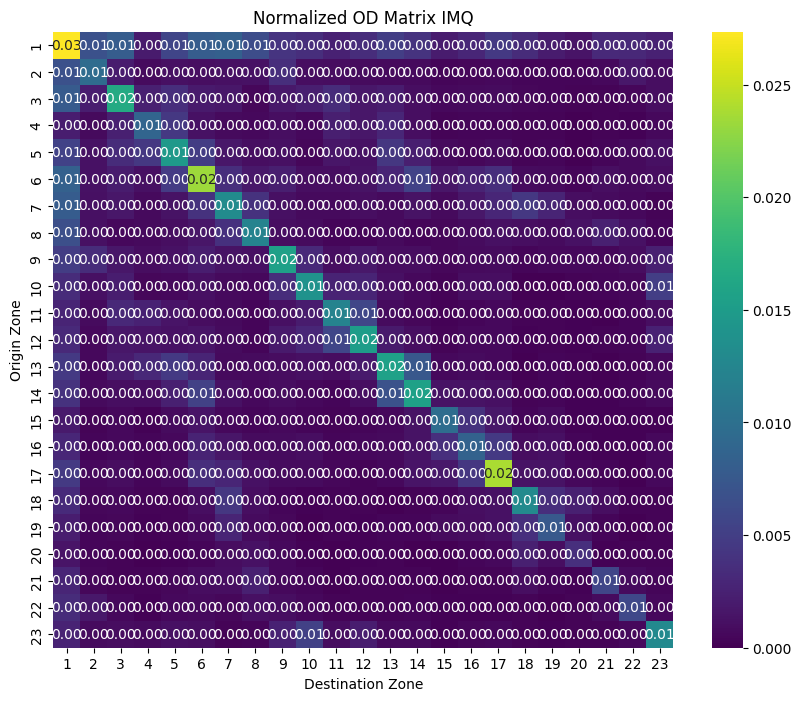

In [51]:
max_zone_index = 23
od_matrix_unipol = np.zeros((max_zone_index  , max_zone_index ), dtype=int)
od_matrix_imq = np.zeros((max_zone_index , max_zone_index ), dtype=int)

for _, row in unipol_data.iterrows():
    if 1 <= row['ORI_ZONE'] <= max_zone_index and 1 <= row['DST_ZONE'] <= max_zone_index:
        od_matrix_unipol[row['ORI_ZONE'] -1, row['DST_ZONE']-1 ] += 1

# Compute the OD matrix for IMQ
for _, row in imq_data.iterrows():
    if 1 <= row['ORI_ZONE'] <= max_zone_index and 1 <= row['DST_ZONE'] <= max_zone_index:
        od_matrix_imq[row['ORI_ZONE']-1 , row['DST_ZONE'] -1] += 1

od_matrix_unipol_normalized = od_matrix_unipol / od_matrix_unipol.sum()
od_matrix_imq_normalized = od_matrix_imq / od_matrix_imq.sum()

od_matrix_unipol_flat = od_matrix_unipol_normalized.flatten()
od_matrix_imq_flat = od_matrix_imq_normalized.flatten()

distance = compute_dm2(od_matrix_unipol_normalized, od_matrix_imq_normalized)
print(f"Distance between normalized UnipolTech and IMQ OD matrices: {distance}")


plt.figure(figsize=(10, 8))
sns.heatmap(od_matrix_unipol_normalized, annot=True, fmt=".2f", cmap="viridis",xticklabels=range(1, 24), yticklabels=range(1, 24))
plt.title("Normalized OD Matrix UnipolTech")
plt.xlabel("Destination Zone")
plt.ylabel("Origin Zone")

plt.figure(figsize=(10, 8))
sns.heatmap(od_matrix_imq_normalized, annot=True, fmt=".2f", cmap="viridis",xticklabels=range(1, 24), yticklabels=range(1, 24))
plt.title("Normalized OD Matrix IMQ")
plt.xlabel("Destination Zone")
plt.ylabel("Origin Zone")
plt.show()

In [58]:
#3a
unipol_groups = unipol_data.groupby(['genere', 'eta_approx', 'commerciale'])

imq_groups = imq_data.groupby(['GENDER', 'AGE'])

max_zone_index = 23
def compute_od_matrix(group, max_zone_index):
    od_matrix = np.zeros((max_zone_index , max_zone_index ), dtype=int)
    for _, row in group.iterrows():
        if row['ORI_ZONE'] <= max_zone_index and row['DST_ZONE'] <= max_zone_index:
            od_matrix[row['ORI_ZONE']-1, row['DST_ZONE']-1] += 1
    return od_matrix

unipol_od_matrices = {name: compute_od_matrix(group, max_zone_index) for name, group in unipol_groups}

imq_od_matrices = {name: compute_od_matrix(group, max_zone_index) for name, group in imq_groups}

def normalize_od_matrix(od_matrix):
    return od_matrix / od_matrix.sum()

unipol_od_matrices_normalized = {name: normalize_od_matrix(matrix) for name, matrix in unipol_od_matrices.items()}

imq_od_matrices_normalized = {name: normalize_od_matrix(matrix) for name, matrix in imq_od_matrices.items()}




similarities = {}
for unipol_name, unipol_matrix in unipol_od_matrices_normalized.items():
    for imq_name, imq_matrix in imq_od_matrices_normalized.items():
        similarity = compute_dm2(unipol_matrix, imq_matrix)
        similarities[(unipol_name, imq_name)] = similarity

for (unipol_name, imq_name), similarity in similarities.items():
    unipol_gender, unipol_age, unipol_commercial = unipol_name
    imq_gen, imq_age = imq_name
    print(f"Similarity between UnipolTech group (Gender: {unipol_gender}, Age: {unipol_age}, Commercial: {unipol_commercial}) "
          f"and IMQ group (Gender: {imq_gen}, age: {imq_age}): {similarity}")

Similarity between UnipolTech group (Gender: F, Age: 3, Commercial: N) and IMQ group (Gender: 1, age: 1): 0.1259285664008585
Similarity between UnipolTech group (Gender: F, Age: 3, Commercial: N) and IMQ group (Gender: 1, age: 2): 0.12935336409876777
Similarity between UnipolTech group (Gender: F, Age: 3, Commercial: N) and IMQ group (Gender: 1, age: 3): 0.13144473531057546
Similarity between UnipolTech group (Gender: F, Age: 3, Commercial: N) and IMQ group (Gender: 1, age: 4): 0.12885482365647696
Similarity between UnipolTech group (Gender: F, Age: 3, Commercial: N) and IMQ group (Gender: 2, age: 1): 0.15184748827008787
Similarity between UnipolTech group (Gender: F, Age: 3, Commercial: N) and IMQ group (Gender: 2, age: 2): 0.12845826114149858
Similarity between UnipolTech group (Gender: F, Age: 3, Commercial: N) and IMQ group (Gender: 2, age: 3): 0.13731841616760182
Similarity between UnipolTech group (Gender: F, Age: 3, Commercial: N) and IMQ group (Gender: 2, age: 4): 0.14143004490

Selected UnipolTech Group: ('F', 47, 'N')
Selected IMQ Group: (1, 4)


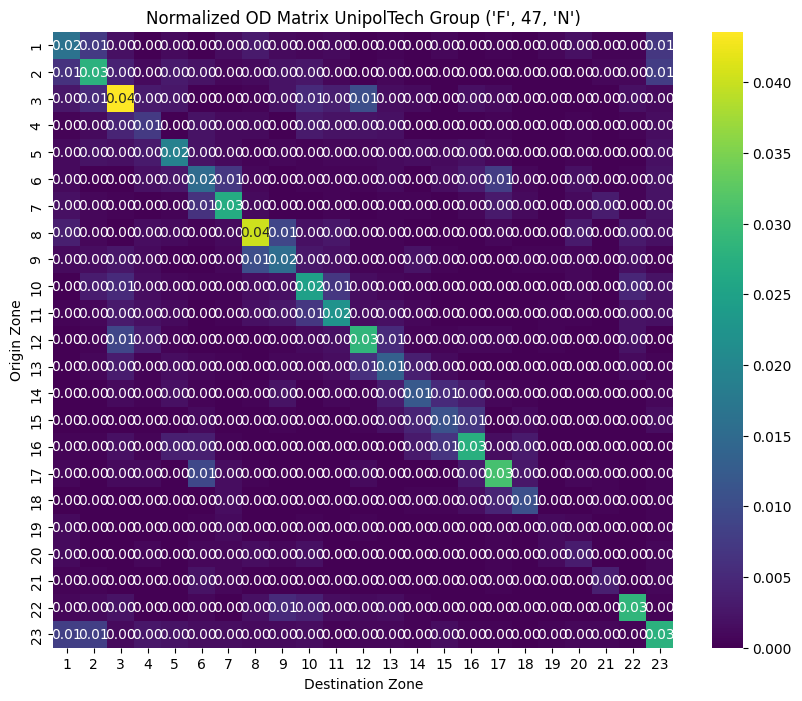

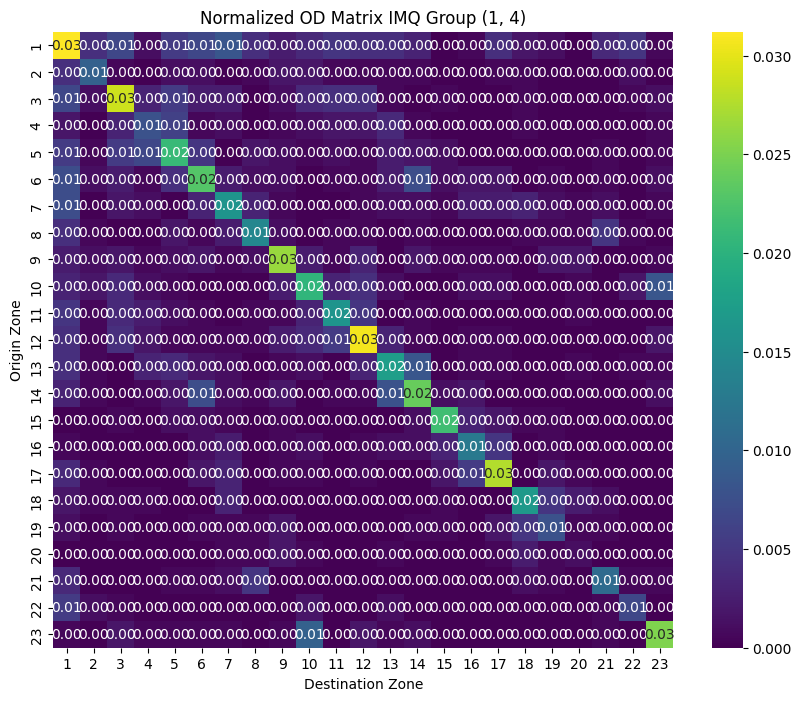

In [60]:
unipol_od_matrices_normalized = {
    (gender, int(age), commercial): matrix
    for (gender, age, commercial), matrix in unipol_od_matrices_normalized.items()
}

imq_od_matrices_normalized = {
    (int(gen), int(age)): matrix
    for (gen, age), matrix in imq_od_matrices_normalized.items()
}


selected_unipol_group = ('F', 47, 'N')  #gender, age , commercial
selected_imq_group = (1,4)  # gender - age

if selected_unipol_group not in unipol_od_matrices_normalized:
    print(f"UnipolTech group {selected_unipol_group} does not exist.")
else:
    print(f"Selected UnipolTech Group: {selected_unipol_group}")

if selected_imq_group not in imq_od_matrices_normalized:
    print(f"IMQ group {selected_imq_group} does not exist.")
else:
    print(f"Selected IMQ Group: {selected_imq_group}")

if selected_unipol_group in unipol_od_matrices_normalized:
    plt.figure(figsize=(10, 8))
    sns.heatmap(unipol_od_matrices_normalized[selected_unipol_group], annot=True, fmt=".2f", cmap="viridis", xticklabels=range(1, 24), yticklabels=range(1, 24))
    plt.title(f"Normalized OD Matrix UnipolTech Group {selected_unipol_group}")
    plt.xlabel("Destination Zone")
    plt.ylabel("Origin Zone")

if selected_imq_group in imq_od_matrices_normalized:
    plt.figure(figsize=(10, 8))
    sns.heatmap(imq_od_matrices_normalized[selected_imq_group], annot=True, fmt=".2f", cmap="viridis", xticklabels=range(1, 24), yticklabels=range(1, 24))
    plt.title(f"Normalized OD Matrix IMQ Group {selected_imq_group}")
    plt.xlabel("Destination Zone")
    plt.ylabel("Origin Zone")

plt.show()

In [61]:
gender_differences = {}
all_differences = {}
max_difference_age_groups = {}

for gender in imq_data['GENDER'].unique():
    age_groups = [key for key in imq_od_matrices_normalized.keys() if key[0] == gender]
    differences = []
    age_group_pairs = []
    for i in range(len(age_groups)):
        for j in range(i + 1, len(age_groups)):
            age_group1 = age_groups[i]
            age_group2 = age_groups[j]
            similarity = compute_dm2(imq_od_matrices_normalized[age_group1], imq_od_matrices_normalized[age_group2])
            differences.append(similarity)
            age_group_pairs.append((age_group1[1], age_group2[1]))
    all_differences[gender] = list(zip(age_group_pairs, differences))
    max_difference_index = np.argmax(differences)
    gender_differences[gender] = differences[max_difference_index]
    max_difference_age_groups[gender] = age_group_pairs[max_difference_index]


for gender, diffs in all_differences.items():
    print(f"Differences for gender {gender}:")
    for (age_group1, age_group2), difference in diffs:
        print(f"  Between ages {age_group1} and {age_group2}: {difference}")


for gender, difference in gender_differences.items():
    age_group1, age_group2 = max_difference_age_groups[gender]
    print(f"Maximum difference in behavior across age groups for gender {gender}: {difference} (between ages {age_group1} and {age_group2})")

max_difference_gender = max(gender_differences, key=gender_differences.get)
print(f"Gender with greater differences in behavior across age groups: {max_difference_gender}")

Differences for gender 1:
  Between ages 1 and 2: 0.020071442603804248
  Between ages 1 and 3: 0.02734102042003115
  Between ages 1 and 4: 0.02999621801896525
  Between ages 2 and 3: 0.015279586016670793
  Between ages 2 and 4: 0.025907884291120044
  Between ages 3 and 4: 0.025515839441018557
Differences for gender 2:
  Between ages 1 and 2: 0.03305667155545599
  Between ages 1 and 3: 0.032351350504795186
  Between ages 1 and 4: 0.03888996687820908
  Between ages 2 and 3: 0.01474632350260709
  Between ages 2 and 4: 0.028046720109453048
  Between ages 3 and 4: 0.02063691290422104
Maximum difference in behavior across age groups for gender 1: 0.02999621801896525 (between ages 1 and 4)
Maximum difference in behavior across age groups for gender 2: 0.03888996687820908 (between ages 1 and 4)
Gender with greater differences in behavior across age groups: 2


In [64]:
car2go_data = pd.DataFrame(list(Bookings_col.find()))
enjoy_data = pd.DataFrame(list(Enjoy_Bookings_col.find()))

with open('./data/IMQ/Zone/TorinoZonescol.geojson') as file:
    data = json.load(file)

zones = []
for feature in data['features']:
    coordinates = feature['geometry']['coordinates']
    if feature['geometry']['type'] == 'Polygon':
        zones.append(Polygon(coordinates[0]))
    elif feature['geometry']['type'] == 'MultiPolygon':
        for polygon in coordinates:
            zones.append(Polygon(polygon[0]))


zone_gdf = gpd.GeoDataFrame(geometry=zones)


def find_zone(lat, lon):
    point = Point(lon, lat)
    for i, zone in enumerate(zones):
        if zone.contains(point):
            return i
    return -1

def compute_od_matrix(group, max_zone_index):
    od_matrix = np.zeros((max_zone_index + 1, max_zone_index + 1), dtype=int)
    for _, row in group.iterrows():
        if row['origin'] <= max_zone_index and row['dest'] <= max_zone_index:
            od_matrix[row['origin'], row['dest']] += 1
    return od_matrix



car2go_od_matrix_normalized = normalize_od_matrix(od_matrix)
enjoy_od_matrix_normalized = normalize_od_matrix(od_matrix_e)

similarities = {}
for name, matrix in imq_od_matrices_normalized.items():
    car2go_similarity = compute_dm2(matrix, car2go_od_matrix_normalized)
    enjoy_similarity = compute_dm2(matrix, enjoy_od_matrix_normalized)
    similarities[name] = {'Car2GO': car2go_similarity, 'Enjoy': enjoy_similarity}

for name, sim in similarities.items():
    print(f"Similarity for group {name}: Car2GO = {sim['Car2GO']}, Enjoy = {sim['Enjoy']}")

max_car2go_similarity = min(similarities.items(), key=lambda x: x[1]['Car2GO'])
max_enjoy_similarity = min(similarities.items(), key=lambda x: x[1]['Enjoy'])

print(f"Maximum similarity for Car2GO: Group {max_car2go_similarity[0]} with similarity {max_car2go_similarity[1]['Car2GO']}")
print(f"Maximum similarity for Enjoy: Group {max_enjoy_similarity[0]} with similarity {max_enjoy_similarity[1]['Enjoy']}")

Similarity for group (1, 1): Car2GO = 0.04163615211968903, Enjoy = 0.03049199743050107
Similarity for group (1, 2): Car2GO = 0.03679724060824619, Enjoy = 0.025576314543173446
Similarity for group (1, 3): Car2GO = 0.030571431574553918, Enjoy = 0.028352032766779396
Similarity for group (1, 4): Car2GO = 0.0328169721054407, Enjoy = 0.033068731915626495
Similarity for group (2, 1): Car2GO = 0.04367401677535119, Enjoy = 0.03880273669056909
Similarity for group (2, 2): Car2GO = 0.03213930742508399, Enjoy = 0.03082696759317814
Similarity for group (2, 3): Car2GO = 0.03582386751507933, Enjoy = 0.029042056163377735
Similarity for group (2, 4): Car2GO = 0.03968300276880196, Enjoy = 0.04149342452054827
Maximum similarity for Car2GO: Group (1, 3) with similarity 0.030571431574553918
Maximum similarity for Enjoy: Group (1, 2) with similarity 0.025576314543173446
